In [1]:
!gdown -q 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[[0.         0.        ]
 [0.00096008 0.01005528]
 [0.01045864 0.01728405]
 [0.00087922 0.03029027]
 [0.00991727 0.03916803]] [0 1 2]
(300, 2) (300,)

EPOCH 1:	Training loss: 0.898	Validation loss: 1.160

EPOCH 2:	Training loss: 0.842	Validation loss: 0.875

EPOCH 3:	Training loss: 0.762	Validation loss: 0.969

EPOCH 4:	Training loss: 0.800	Validation loss: 0.944

EPOCH 5:	Training loss: 0.776	Validation loss: 0.880

EPOCH 6:	Training loss: 0.758	Validation loss: 1.153

EPOCH 7:	Training loss: 0.854	Validation loss: 0.832

EPOCH 8:	Training loss: 0.667	Validation loss: 0.863

EPOCH 9:	Training loss: 0.739	Validation loss: 1.659

EPOCH 10:	Training loss: 0.768	Validation loss: 0.709

EPOCH 11:	Training loss: 0.623	Validation loss: 0.685

EPOCH 12:	Training loss: 0.688	Validation loss: 0.753

EPOCH 13:	Training loss: 0.621	Validation loss: 0.689

EPOCH 14:	Training loss: 0.583	Validation loss: 0.631

EPOCH 15:	Training loss: 0.573	Validation loss: 0.735

EPOCH 16:	Training loss: 0.583	Va

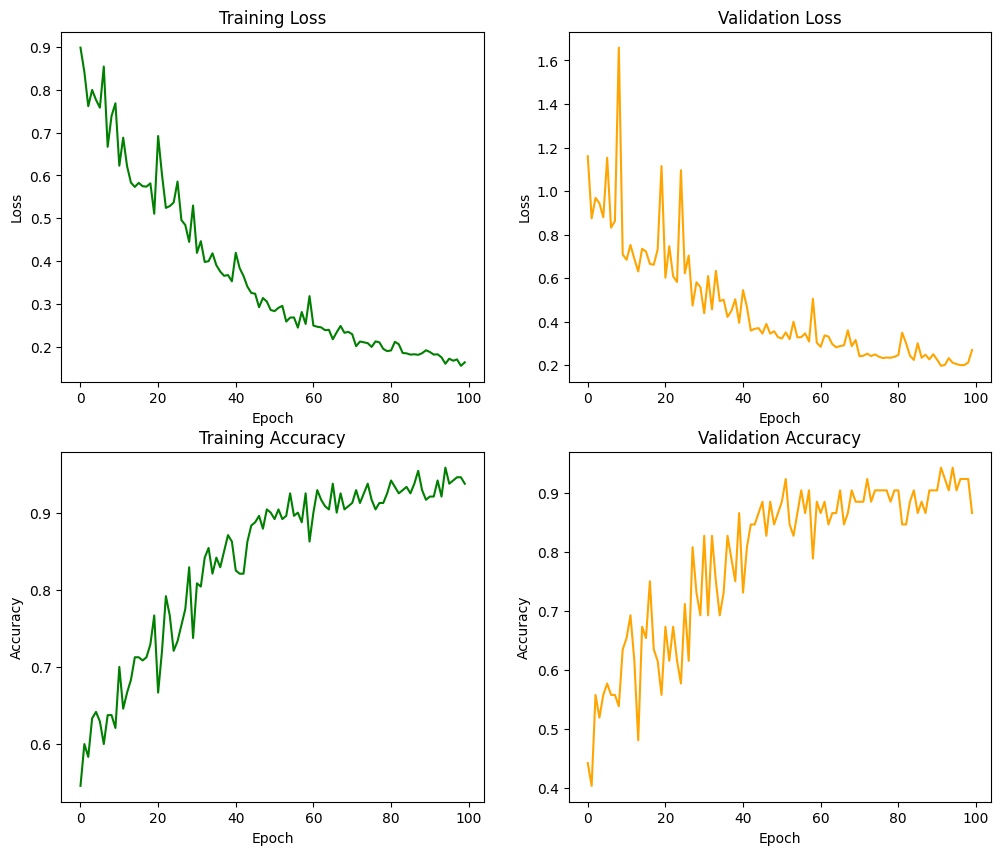

Evaluation on test set:
Accuracy: 0.875


In [4]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)


def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy


if __name__ == "__main__":
    data_path = '/content/NonLinear_data.npy'
    data = np.load(data_path, allow_pickle=True).item()
    X, y = data['X'], data['labels']
    print(X[:5], np.unique(y))
    print(X.shape, y.shape)

    val_size = .2
    test_size = .125
    is_shuffle = True

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, shuffle=is_shuffle,
                                                  random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=test_size, shuffle=is_shuffle,
                                                random_state=random_state)
    normalizer = StandardScaler()
    X_train = normalizer.fit_transform(X_train)
    X_val = normalizer.transform(X_val)
    X_test = normalizer.transform(X_test)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    batch_size = 32
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    test_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    model = MLP(
        input_dims=X_train.shape[1],
        hidden_dims=512,
        output_dims=torch.unique(y_train).shape[0]
    ).to(device)

    lr = 1e-1
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    epochs = 100
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        train_loss = 0.0
        train_target = []
        train_predict = []
        model.train()

        for X_samples, y_samples in train_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device).long()
            optimizer.zero_grad()
            outputs = model(X_samples)
            loss = criterion(outputs, y_samples)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            train_predict.append(outputs.detach().cpu())
            train_target.append(y_samples.cpu())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        train_predict = torch.cat(train_predict)
        train_target = torch.cat(train_target)
        train_acc = compute_accuracy(train_predict, train_target)
        train_accs.append(train_acc)

        val_loss = 0.0
        val_target = []
        val_predict = []

        model.eval()
        with torch.no_grad():
            for X_samples, y_samples in val_loader:
                X_samples = X_samples.to(device)
                y_samples = y_samples.to(device).long()
                outputs = model(X_samples)
                val_loss += criterion(outputs, y_samples).item()

                val_predict.append(outputs.cpu())
                val_target.append(y_samples.cpu())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)

        print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0, 0].plot(train_losses, color='green')
    ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
    ax[0, 0].set_title('Training Loss')

    ax[0, 1].plot(val_losses, color='orange')
    ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
    ax[0, 1].set_title('Validation Loss')

    ax[1, 0].plot(train_accs, color='green')
    ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
    ax[1, 0].set_title('Training Accuracy')

    ax[1, 1].plot(val_accs, color='orange')
    ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
    ax[1, 1].set_title('Validation Accuracy')

    plt.show()

    test_target = []
    test_predict = []
    model.eval()

    with torch.no_grad():
        for X_samples, y_samples in test_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)

            test_predict.append(outputs.cpu())
            test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')